### Загрузка библиотек, весов для word2vec и импорты

In [2]:
!pip install -q transformers

     |████████████████████████████████| 2.1MB 8.4MB/s 
     |████████████████████████████████| 901kB 52.7MB/s 
     |████████████████████████████████| 3.3MB 43.7MB/s 


In [3]:
import re
import os
import json
import shutil
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn, optim
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, Sampler, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
sns.set_style('dark')

In [4]:
import warnings
warnings.simplefilter("ignore")

In [5]:
shutil.copy('.//drive//MyDrive//Hack24//hackathon-spring-2021.csv.gz', './/')

'.//hackathon-spring-2021.csv.gz'

In [6]:
!gzip -d hackathon-spring-2021.csv.gz

### Первый взгляд на данные

In [7]:
data_frame = pd.read_csv('.//hackathon-spring-2021.csv')

In [8]:
data_frame = pd.concat((data_frame.iloc[:, 1:], pd.get_dummies(data_frame['social_type'])), axis=1)

In [9]:
data_frame.head()

,text,has_images,has_videos,url,likes,comments,reposts,views,is_repost,created_date,updated_date,version,author_id,id,author_subscribers,odnoklassniki,telegram,vk
0,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,20,2,0,-1,0,2021-04-07 06:30:00,2021-04-07 16:40:11,2,42559086985346,group/42559086985346/topic/152651712709506,682150,1,0,0
1,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,23,3,0,-1,0,2021-04-07 06:30:00,2021-04-08 15:07:33,4,42559086985346,group/42559086985346/topic/152651712709506,682138,1,0,0
2,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,23,3,0,-1,0,2021-04-06 21:00:00,2021-04-09 05:17:45,6,42559086985346,group/42559086985346/topic/152651712709506,682137,1,0,0
3,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,23,3,0,-1,0,2021-04-06 21:00:00,2021-04-09 17:17:49,8,42559086985346,group/42559086985346/topic/152651712709506,682149,1,0,0
4,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,23,3,0,-1,0,2021-04-06 21:00:00,2021-04-10 06:12:21,10,42559086985346,group/42559086985346/topic/152651712709506,682149,1,0,0


In [10]:
data_frame['created_date'] = pd.to_datetime(data_frame.created_date)
data_frame['updated_date'] = pd.to_datetime(data_frame.updated_date)

In [11]:
col_data = ['has_images', 'has_videos', 'author_subscribers', 'lenght', 'odnoklassniki', 'telegram', 'vk']
target_col = ['likes', 'comments', 'reposts', 'views']

In [12]:
# preprocessing function for text from odnoklassniki
def html2text(text):
    text = re.sub(r'[^а-яА-Я.,:?!]', ' ', ''.join(re.split(r'<[^<>]+>', str(text))))
    text = ' '.join(text.split())
    return text

In [13]:
data_frame['text'] = data_frame.text.apply(html2text)

In [14]:
# create new feature
data_frame['lenght'] = data_frame.text.apply(len)

In [15]:
statistic = data_frame.groupby(by='id').agg({'has_images':'max',
                                             'has_videos':'max'})

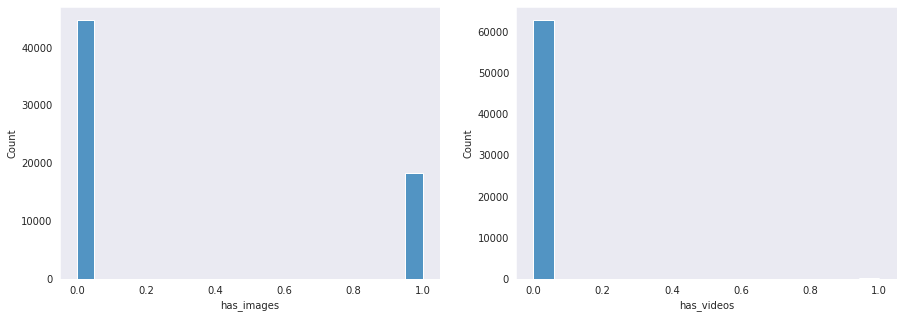

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=statistic, x='has_images')
plt.subplot(1, 2, 2)
sns.histplot(data=statistic, x='has_videos')
plt.show()

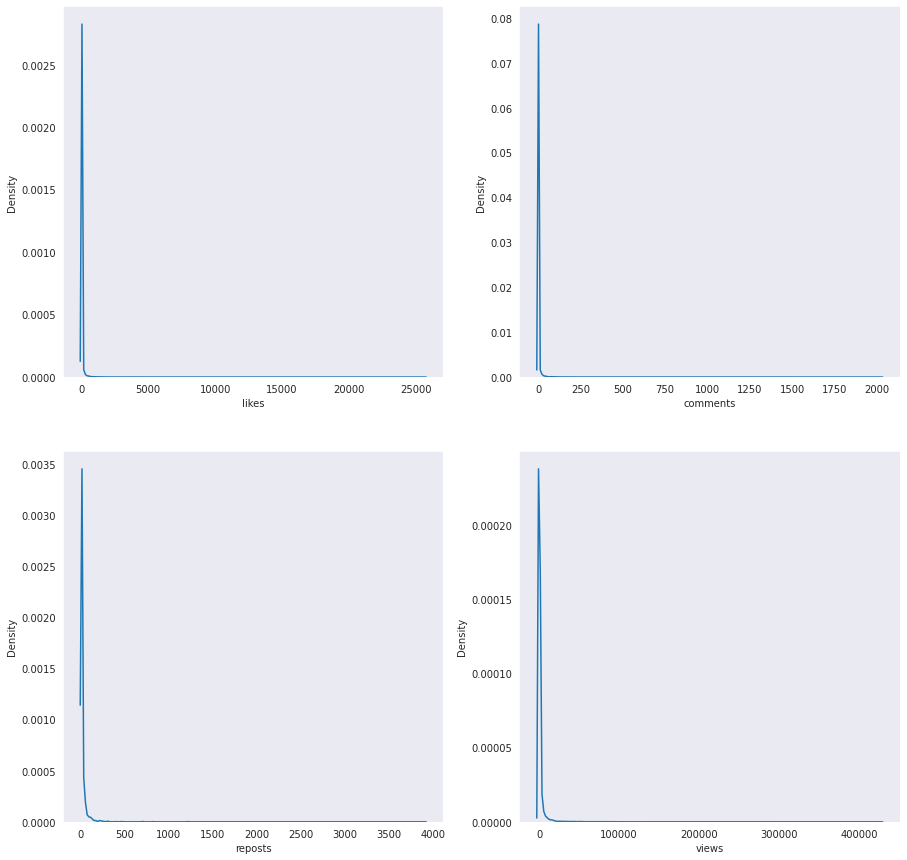

In [17]:
# likes comments reposts views
plt.figure(figsize=(15, 15))
for i, param in enumerate(['likes', 'comments', 'reposts', 'views'], 1):
    statistic = data_frame[data_frame[param] != -1].groupby(by='id').agg({param:'max'})
    plt.subplot(2, 2, i)
    sns.kdeplot(data=statistic, x=param)
plt.show()

#### 'likes' 'comments' 'reposts' 'views' явно распределены в соответствии с логнормальным з-ном распределения. 
### Отнормируем столбецы 'author_subscribers', 'lenght', которые будут входными данными модели, попробуем привести к нормальному распределению выходные значения

In [18]:
scaller_subscribers = StandardScaler()
data_frame[['author_subscribers', 'lenght']] = scaller_subscribers.fit_transform(data_frame[['author_subscribers', 'lenght']])

In [19]:
target_transformed = pd.DataFrame(data=np.hstack((np.log(data_frame[target_col] + 1e-5), data_frame.id[:, np.newaxis])), columns=target_col + ['id'])

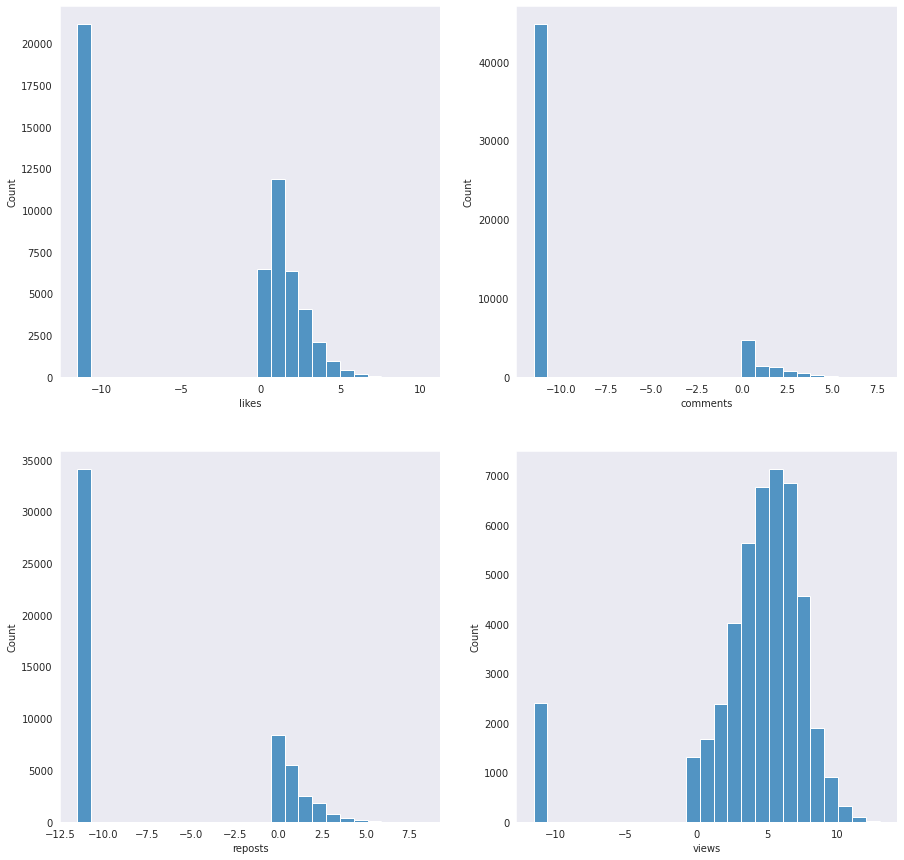

In [20]:
# likes comments reposts views
plt.figure(figsize=(15, 15))
for i, param in enumerate(['likes', 'comments', 'reposts', 'views'], 1):
    statistic = target_transformed[data_frame[param] != -1].groupby(by='id').agg({param:'max'})
    plt.subplot(2, 2, i)
    sns.histplot(data=statistic, x=param, bins=25)
plt.show()

#### Какие выводы можно сделать на основе данных:
1. В данных много примеров с 0, которые и создают на этапе первого просмотра график похожий на логнормальное распределение;
2. Все параметры имеют явно отделимую часть - 0-ые значения на графике;
3. Ненулевые значения 'likes' имеют логнормальное распределение;
3. Ненулевые 'comments' и 'reposts' исходя из полученного разбиения на ячейки гистограммы рапределены экспоненциально;
4. Ненулевые просмотры нормально распределены.


### Поэтому к целевым переменным добавим новые значеня, которые будут иметь бинарные значения 'likes_is_0' 'comments_is_0' 'reposts_is_0' 'views_is_0', так что помимо регрессии будет решаться задача классификации

In [21]:
scaller_output = StandardScaler()
data_frame[target_col] = scaller_output.fit_transform(data_frame[target_col])

In [22]:
for col in target_col:
    data_frame[col+'_is_0'] = (data_frame[col] == 0).astype(np.int8)

In [23]:
target_col = target_col + ['likes_is_0', 'comments_is_0', 'reposts_is_0', 'views_is_0']

### Разделение даных на обучающую и тестовую выборку

In [24]:
data_for_split = data_frame.groupby(by=['author_id', 'id'], as_index=False).agg({'likes':'max', 'comments':'max', 'reposts':'max', 'views':'max', 'url':'count'})
data_for_split = data_for_split[data_for_split.url > 6]

In [25]:
def split_data(data, test_size, stratify):
    index = np.zeros(data.shape[0], dtype=np.bool)
    stratify = stratify.to_numpy()
    for i in range(index.shape[0]):
        if np.sum(np.all(stratify == stratify[i], axis=1)) > 1:
            index[i] = True
    not_frequent_data = data[~index]
    train, test = train_test_split(data[index], test_size=test_size, stratify=stratify[index])
    return pd.concat((not_frequent_data, train)), test

In [26]:
train, test = split_data(data_for_split, test_size=0.1, stratify=data_for_split[['likes', 'comments', 'reposts', 'views']])

In [27]:
print('Train shape:', train.shape[0],
      '\nTest shape: ', test.shape[0])

Train shape: 10703 
Test shape:  1090


In [28]:
model_class, tokenizer_class, pretrained_weights = DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased'
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert = model_class.from_pretrained(pretrained_weights)

In [29]:
def return_one(x):
    return x.iloc[0]

In [30]:
def return_ndarray(x):
    try:
        return x.to_list()
    except:
        print(x)

In [31]:
def create_data_for_dataset(csv):
    data = csv.groupby(by=['id', 'author_id'], as_index=False)
    data = data.agg({'text':return_one,
                          'author_subscribers': return_one,
                          'has_images': return_one,
                          'has_videos': return_one,
                          'lenght': return_one,
                          'odnoklassniki': return_one,
                          'telegram': return_one,
                          'vk': return_one,
                          'comments': return_ndarray,
                          'comments_is_0': return_ndarray,
                          'likes': return_ndarray,
                          'likes_is_0': return_ndarray,
                          'reposts': return_ndarray,
                          'reposts_is_0': return_ndarray,
                          'views': return_ndarray,
                          'views_is_0': return_ndarray})
    return data

class PostsDataset(Dataset):
    def __init__(self, data, tokenizer, id, max_size=200):
        self.max_size = max_size
        self.data = data.merge(id,how='right')
        self.data['text'] = data.text.apply(lambda x:tokenizer.encode(x, add_special_tokens=True))
        
    def __getitem__(self, idx):
        return {'text': self.data.iloc[idx, 2][:self.max_size],
                'data': self.data.iloc[idx, 3:10],
                'target': np.array(self.data.iloc[idx, 10:].to_list())[:, :7]}

    def __len__(self):
        return len(self.data)

d = create_data_for_dataset(data_frame)

train_dataset = PostsDataset(d, tokenizer, train[['id', 'author_id']], max_size=100)
test_dataset = PostsDataset(d, tokenizer, test[['id', 'author_id']], max_size=100)

Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors


In [32]:
def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in values])

    return padded

def collate_fn(batch):

    inputs = []
    labels = []
    data = []
    for elem in batch:
        inputs.append(elem['text'])
        labels.append(elem['target'])
        data.append(elem['data'])

    inputs = get_padded(inputs) # padded inputs
    attention_mask = np.where(inputs != 0, 1, 0)
    return {"inputs": torch.tensor(inputs), "labels": torch.FloatTensor(labels), 'attention_mask' : torch.tensor(attention_mask), 'data':torch.FloatTensor(data)}

train_loader = DataLoader(train_dataset, batch_size=100, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=100, collate_fn=collate_fn)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
class Monster(nn.Module):
    def __init__(self, emb_dim=50, dropout=0.5):
        super().__init__()
        self.bert = bert
        self.emb = nn.Embedding(num_embeddings=8, embedding_dim=emb_dim)
        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=768, dropout=dropout)
        self.regressor = nn.Sequential(
            nn.Linear(768 * 2 + 7, 300),
            nn.Dropout(p=dropout),
            nn.ReLU(inplace=False),
            nn.Linear(300, 8)
        )
        self.activ = nn.Sigmoid()

    def forward(self, x, atten, data):
        with torch.autograd.set_detect_anomaly(True):
            x = self.bert(x, atten)['last_hidden_state'][:, 0, :]
            positions = [self.emb((i * torch.ones((1, x.size(0)), dtype=torch.long)).to(device)) for i in range(1, 8)]
            c = torch.zeros((1, x.size(0), 768)).to(device)
            h = x.unsqueeze(0).contiguous()
            outputs = []
            for i in range(7):
                # print(positions[i].shape, h.shape, c.shape)
                output, (h, c) = self.rnn(positions[i], (h, c))
                output, hidden = output.squeeze(), h.squeeze()
                # print(output.shape, hidden.shape, c.shape)
                input = torch.cat((output, hidden, data), dim=1)
                # print(input.shape, data.shape)
                out = self.regressor(input)
                out[:, 1::2] = self.activ(out[:, 1::2])
                out[:, ::2] = out[:, ::2] * (1 - out[:, 1::2].detach())
                outputs.append(out.unsqueeze(2))

        return torch.cat(outputs, dim=2)

In [35]:
model = Monster().to(device)

### Обучение

In [36]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()

    epoch_loss = 0

    with torch.set_grad_enabled(True):
        for batch in loader:
            inputs = batch['inputs'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            data = batch['data'].to(device)

            optimizer.zero_grad()

            output = model(inputs, attention_mask, data)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.size(0)

    avg_loss = epoch_loss / len(loader)
    print('Train Loss:', avg_loss)
    return model, avg_loss

def validation_epoch(model, loader, criterion):
    model.eval()

    epoch_loss = 0
    
    with torch.no_grad():
        for batch in loader:
            inputs = batch['inputs'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            data = batch['data'].to(device)

            output = model(inputs, attention_mask, data)

            loss = criterion(output, labels)

            epoch_loss += loss.item() * data.size(0)

    avg_loss = epoch_loss / len(loader)
    print('Val Loss:', avg_loss)
    return avg_loss

In [37]:
loader = {'train':train_loader,
          'val':test_loader}

In [38]:
def train_model(model, loader, n_epoch, max_iter_grow_val_loss=3):
    min_loss = np.inf
    history = {
        'train':[],
        'val':[]
    }
    criterion = nn.MSELoss()
    finetunning_parametres = list(model.parameters())
    c = 0

    for i in range(n_epoch):
        print('Epoch ', i + 1)
        if i < 15:
            optimizer = optim.Adam(finetunning_parametres[100:], lr=3e-4)
        else:
            optimizer = optim.Adam(finetunning_parametres, lr=3e-4)
        model, train_loss = train_epoch(model, loader['train'], optimizer, criterion)
        history['train'].append(train_loss)
        val_loss = validation_epoch(model, loader['val'], criterion)
        history['val'].append(val_loss)
        if min_loss > val_loss:
            min_loss = val_loss
            best_model = model.state_dict()
        else:
            c += 1
        if c == max_iter_grow_val_loss:
            model.load_state_dict(best_model)
            break

    return model, history

In [39]:
model, history = train_model(model, loader, 30)

Epoch  1
Train Loss: 20.20643442027978
Val Loss: 0.6053762692450122
Epoch  2
Train Loss: 17.60399883927743
Val Loss: 0.5136205040087755
Epoch  3
Train Loss: 16.97914154098274
Val Loss: 0.4490516952831637
Epoch  4
Train Loss: 16.47428077905163
Val Loss: 0.41329225567592814
Epoch  5
Train Loss: 16.12363917663633
Val Loss: 0.385029576507143
Epoch  6
Train Loss: 15.758847338324241
Val Loss: 0.37238398799672723
Epoch  7
Train Loss: 15.471119035382461
Val Loss: 0.356741784860126
Epoch  8
Train Loss: 15.220409016826629
Val Loss: 0.3418220861137591
Epoch  9
Train Loss: 14.993393592698137
Val Loss: 0.3272286332635717
Epoch  10
Train Loss: 14.75401304055359
Val Loss: 0.31571689231151884
Epoch  11
Train Loss: 14.486965171544364
Val Loss: 0.294259607961232
Epoch  12
Train Loss: 14.299702620767574
Val Loss: 0.2858095825649798
Epoch  13
Train Loss: 14.077313897868239
Val Loss: 0.26853869669139385
Epoch  14
Train Loss: 13.855157443818085
Val Loss: 0.255552742164582
Epoch  15
Train Loss: 13.6867995765

In [40]:
weight = np.array([0.3, 0.3, 0.3, 0.1])
weight = weight.reshape((4, 1))

In [41]:
def eval(model, loader, scaller):
    diff = 0
    count = 0
    with torch.no_grad():
        for batch in loader:
            inputs = batch['inputs'].to(device)
            labels = batch['labels']
            attention_mask = batch['attention_mask'].to(device)
            data = batch['data'].to(device)
            output = model(inputs, attention_mask, data)
            count += output.size(0)
            output = output.to('cpu')
            output_numpy = output.detach().numpy()
            labels_numpy = labels.detach().numpy()        
            for i in range(output.shape[0]):
                lab = np.squeeze(scaller.inverse_transform(labels_numpy[i, 1::2, :].T)).T
                out = np.squeeze(scaller.inverse_transform(output_numpy[i, 1::2, :].T)).T
                output_inverse = np.sum(lab * weight, axis=0) / out.mean(axis=0)
                labels_inverse = np.sum(lab * weight, axis=0) / lab.mean(axis=0)
                diff += np.sum(np.abs(output_inverse  - labels_inverse))
    return diff / count, out, lab

In [42]:
metric, pred_label, true_label = eval(model, test_loader, scaller_output)

In [43]:
print(metric)

0.0024817806955958173


In [44]:
print(pred_label.astype(np.float))

[[ 4.93682766e+00  4.89639425e+00  4.89549828e+00  4.89351749e+00
   4.89329052e+00  4.89325809e+00  4.89335060e+00]
 [-9.55959875e-03 -1.36737349e-02 -1.37531022e-02 -1.39310509e-02
  -1.39519051e-02 -1.39549254e-02 -1.39465528e-02]
 [ 1.23047024e-01  1.19677946e-01  1.19598374e-01  1.19432487e-01
   1.19412750e-01  1.19409919e-01  1.19417891e-01]
 [ 1.89285107e+03  1.88938171e+03  1.88930054e+03  1.88913464e+03
   1.88911597e+03  1.88911340e+03  1.88912085e+03]]


In [45]:
print(true_label.astype(np.float))

[[ 4.89323187e+00  4.89323187e+00  4.89323187e+00  4.89323187e+00
   4.89323187e+00  4.89323187e+00  4.89323187e+00]
 [-1.39573673e-02 -1.39573673e-02 -1.39573673e-02 -1.39573673e-02
  -1.39573673e-02 -1.39573673e-02 -1.39573673e-02]
 [ 1.19407617e-01  1.19407617e-01  1.19407617e-01  1.19407617e-01
   1.19407617e-01  1.19407617e-01  1.19407617e-01]
 [ 1.88911133e+03  1.88911133e+03  1.88911133e+03  1.88911133e+03
   1.88911133e+03  1.88911133e+03  1.88911133e+03]]
